# Digital Signal and Image Managment

<a href="https://drive.google.com/open?id=1yVOocndxZ8p2l_5sZWuqa6xcdffqsIB0">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Assignment 5

Implementare uno script di classificazione basato sul fine tuning di feature neurali, a partire dalle istruzioni viste ad esercitazione.

Verificare l'impatto sulle performance dato da:
* Una diversa architettura
* Operazioni di data augmentation

Innanzitutto importiamo i pacchetti necessari ad assolvere ai nostri task.

### Packages

In [1]:
#----- set tf version and install packages
%tensorflow_version 2.x
!pip install -q livelossplot
!pip install -q keras==2.3.0

TensorFlow 2.x selected.
     |████████████████████████████████| 378kB 9.3MB/s 


In [0]:
#----- dl utilities
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, LeakyReLU
from keras.optimizers import Adam, RMSprop, Nadam, SGD
from livelossplot.keras import PlotLossesCallback
from keras.callbacks.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as preprocess_input_vgg16
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50
from keras.utils import to_categorical
from keras.callbacks.tensorboard_v1 import TensorBoard

#----- prepare colab env
from google.colab import drive

#----- utils
import tarfile
from sklearn.metrics import classification_report
from sklearn.datasets import load_files
import cv2 as cv
from tqdm import tqdm
import os

#----- magic trio plus special guest
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Come reti pre-trainate si è deciso di testare la MobileNetV2, la VGG16 e la ResNet50 tutte con pesi **IMAGENET**.

### Set Colab env

Settiamo il nostro Colab environment ed importiamo le immagini.

In [3]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!wget -q https://www.dropbox.com/s/drwy7fq5svwv78p/101_ObjectCategories_split.tar

In [0]:
tar = tarfile.open('101_ObjectCategories_split.tar')
tar.extractall()
tar.close()

In [0]:
#----- **IMPORTANT** set directory where to save and load features previously extracted
save_directory = "gdrive/My Drive/Data.npy"

### Preprocessing

<div align = 'justify'>
<font size = 3>
Per le operazioni di pre-processing si è deciso innanzitutto di creare due data generator, uno per il training set ed uno per il test set. 

Il generatore del training set, oltre a pre-processare le immagini sulla base della rete pre-trainata corrispondente attraverso un'apposita funzione applica anche delle operazioni di data augmentation tra cui:
* Rotazione dell'immagine fino a 25°;
* Shift in larghezza del 20%;
* Shift in altezza del 20%;
* Flip orizzontale;
* Zoom del 20%.
</font>
</div>

In [7]:
train_processing = ImageDataGenerator(preprocessing_function = preprocess_input_resnet50,
                                      rotation_range = 25,
                                      width_shift_range = .2,
                                      height_shift_range = .2,
                                      horizontal_flip = True,
                                      zoom_range = .2)

train_generator = train_processing.flow_from_directory('101_ObjectCategories_split/train/',
                        target_size = (224, 224),
                        color_mode = 'rgb',
                        class_mode = 'categorical',
                        batch_size = 32,
                        shuffle = True,
                        seed = 1)

Found 4600 images belonging to 102 classes.


In [8]:
test_processing = ImageDataGenerator(preprocessing_function = preprocess_input_resnet50)
test_generator = test_processing.flow_from_directory('101_ObjectCategories_split/test/',
                        target_size = (224, 224),
                        color_mode = 'rgb',
                        class_mode = 'categorical',
                        batch_size = 32,
                        shuffle = True,
                        seed = 1)

Found 4544 images belonging to 102 classes.


<div align = 'justify'>
<font size = 3>
Pur avendo presente che il task principale consiste nell'effettuare fine tuning di una rete pre-trainata si è deciso di procedere con approccio leggermente differente: con l'obiettivo di risparmiare tempo in fase di addestramento dei layer aggiuntivi alla rete già trainata si è deciso di praticare sostanzialmente feature extraction dall'ultimo layer disponibile della rete pre-trainata, di fatto non provocando nessuna alterazione negli output per poi salvare queste features esternamente così da ottenere due risultati apprezzabili:
* Effettuare l'elaborazione delle immagini attraverso la rete pre-trainata una volta sola così da risparmiare molto tempo in fase di addestramento dei layer aggiuntivi;
* Rendere le features rapidamente importabili così che non sia neanche necessario, ogni volta, importare il dataset principale contenente le immagini.
</font>
</div>

### Extract and save features from pre-trained models

<div align = 'justify'>
<font size = 3>
Per effettuare questa procedura di feature extraction si è sostanzialmente definita una funzione per estrarre rapidamente le features attraverso una rete pre-trainata a scelta tra MobileNetV2, VGG16 e ResNet50 per poi salvare il tutto in file .npz.
</font>
</div>

In [0]:
def plot_loss_acc(fitted):
  f, axes = plt.subplots(1,2, figsize = (20,5))
  axes[0].plot(fitted.history['loss'])
  axes[0].plot(fitted.history['val_loss'])
  axes[0].set_title("Loss")

  axes[1].plot(fitted.history['acc'])
  axes[1].plot(fitted.history['val_acc'])
  axes[1].set_title("Accuracy")

In [0]:
def extract_features(nn, data, augmentation = False, epochs = 5):
  '''
  nn = Pre-trained neural net to use
  data = data generator
  augmentation = if you want to augment your data
  epochs = how many cicle of augmentation do you need
  '''
  base_model = nn(include_top = False,
                   weights = 'imagenet',
                   input_shape = (224, 224, 3),
                   pooling='avg')
  
  for layer in base_model.layers:
    layer.trainable = False
  
  dims = []
  for dim in base_model.output_shape:
    if dim == None:
      pass
    else:
      dims.append(dim)
  reshaping = np.prod(np.array(dims))
  
  if augmentation:
    
    #----- data augmentation implementation
    features = []
    labels = []
    for i in range(epochs):
      data.reset()
      print("Augmentation cicle n {}".format(i+1))
      
      lab = []
      print("Labels acquisition...")
      for index in range(len(data)):
        lab.append(data[index][1])
      lab =  np.vstack(lab)
      print("Done\n")

      print("Extracting features...")
      feat = base_model.predict_generator(data, verbose = 1)
      features.append(feat)
      labels.append(lab)
      print("Finished augmentation cicle n {}\n--------------\n".format(i+1))

    features = np.vstack(features)
    labels = np.vstack(labels)
    #print("imgs shape: {}\nlabels shape: {}".format(list_of_augmented_imgs.shape, l_labels.shape))

  else:
      
    labels = []
    for index in range(len(data)):
      labels.append(data[index][1])

    labels = np.vstack(labels)
    features = base_model.predict_generator(data, verbose = 1)
    features = features.reshape((features.shape[0], reshaping))
  
  print("\nDims features {}\nDims labels {}".format(features.shape, labels.shape))

  del dims, reshaping, base_model

  return features, labels

In [0]:
# train_features, train_labels = extract_features(ResNet50, train_generator, augmentation=True, epochs = 10)
# np.savez(os.path.join(save_directory, "resnet50_augmented.npz"), features = train_features, labels = train_labels)

Augmentation cicle n 1
Labels acquisition...
Done

Extracting features...
144/144 [==============================] - 65s 455ms/step
Finished augmentation cicle n 1
--------------

Augmentation cicle n 2
Labels acquisition...
Done

Extracting features...
144/144 [==============================] - 65s 449ms/step
Finished augmentation cicle n 2
--------------

Augmentation cicle n 3
Labels acquisition...
Done

Extracting features...
144/144 [==============================] - 65s 449ms/step
Finished augmentation cicle n 3
--------------

Augmentation cicle n 4
Labels acquisition...
Done

Extracting features...
144/144 [==============================] - 65s 449ms/step
Finished augmentation cicle n 4
--------------

Augmentation cicle n 5
Labels acquisition...
Done

Extracting features...
144/144 [==============================] - 65s 455ms/step
Finished augmentation cicle n 5
--------------

Augmentation cicle n 6
Labels acquisition...
Done

Extracting features...
144/144 [=================

In [0]:
# np.save("gdrive/My Drive/Data.npy/labels_dict.npy", train_generator.class_indices, allow_pickle = True)

In [0]:
# test_features, test_labels = extract_features(ResNet50, test_generator)
# np.savez(os.path.join(save_directory, "resnet50_test.npz"), features = test_features, labels = test_labels)

142/142 [==============================] - 37s 263ms/step

Dims features (4544, 2048)
Dims labels (4544, 102)


### Import data

<div align = 'justify'>
<font size = 3>
A questo punto tutto ciò che è necessario per continuare sono le features estratte dal training set e dal test set, rapide da importare e da utilizzare come dati per fittare i nostri "layer aggiuntivi" così da realizzare il task di fine tuning. Questo verrà effettuato sia sulle immagini pure sia su quelle sottoposte a procedura di data augmentation così da verificare l'impatto dell'utilizzo di questa tecnica sulle prestazioni dei classificatori per questo preciso task.
</font>
</div>

### MobileNetV2

In [47]:
#----- import data
with np.load(os.path.join(save_directory, "mobilenetv2.npz")) as data:
  x_train = data['features']
  y_train = data['labels']

with np.load(os.path.join(save_directory, "mobilenetv2_test.npz")) as data:
  x_test = data['features']
  y_test = data['labels']

labels_dict = np.load("gdrive/My Drive/Data.npy/labels_dict.npy", allow_pickle = True)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((4600, 1280), (4544, 1280), (4600, 102), (4544, 102))

In [0]:
#----- callbacks
es = EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = .1, patience = 5, min_lr = .00001, verbose = 1)

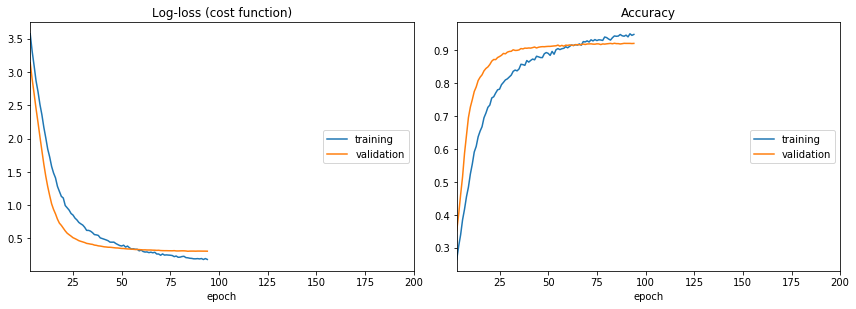

Log-loss (cost function):
training   (min:    0.182, max:    4.593, cur:    0.183)
validation (min:    0.306, max:    3.986, cur:    0.307)

Accuracy:
training   (min:    0.076, max:    0.950, cur:    0.948)
validation (min:    0.184, max:    0.921, cur:    0.921)
Restoring model weights from the end of the best epoch
Epoch 00094: early stopping


In [52]:
#----- model init and learning
init = Input(shape = (x_train.shape[1],))
drop = Dropout(.3)(init)
x = Dense(512, activation = 'relu')(drop)
drop = Dropout(.4)(x)
x = Dense(128, activation='relu')(drop)
drop = Dropout(.3)(x)
out = Dense(y_train.shape[1],
            activation = 'softmax')(drop)


net = Model(inputs = init, outputs = out)

net.compile(optimizer = Adam(learning_rate = .0001),
            loss = 'categorical_crossentropy',
            metrics = ['acc'])

fitted = net.fit(x_train,
                 y_train,
                  epochs = 200,
                 batch_size = 128,
                  validation_data = (x_test, y_test),
                  verbose = 0
                 ,callbacks = [PlotLossesCallback(), es, reduce_lr])

In [53]:
#----- classification report
y_pred = net.predict(x_test)
y_pred = np.argmax(y_pred, axis = -1)

print(classification_report(np.argmax(y_test, axis = -1),
                            y_pred,
                            target_names = labels_dict.all().keys()))

                   precision    recall  f1-score   support

BACKGROUND_Google       0.77      0.78      0.78       234
            Faces       0.99      0.98      0.98       217
       Faces_easy       1.00      0.97      0.98       217
         Leopards       0.97      0.99      0.98       100
       Motorbikes       1.00      1.00      1.00       399
        accordion       1.00      1.00      1.00        27
        airplanes       0.96      0.99      0.98       400
           anchor       0.85      0.52      0.65        21
              ant       0.71      0.57      0.63        21
           barrel       1.00      0.91      0.95        23
             bass       0.90      0.67      0.77        27
           beaver       0.92      0.96      0.94        23
        binocular       0.84      1.00      0.91        16
           bonsai       0.90      0.98      0.94        64
            brain       0.88      0.92      0.90        49
     brontosaurus       0.80      0.76      0.78       

<div align = 'justify'>
<font size = 3>
La rete MobileNetV2 sulle immagini pure, non aumentate raggiunge prestazioni piuttosto buone considerando il dataset. Come si può osservare dal classification report alcune classi sono classificate con grande precisione mentre altre, complice anche la scarsità di osservazioni, non riescono ad essere classificate in modo soddisfaciente.
</font>
</div>

### MobileNetV2 augmented data

In [55]:
#----- import data
with np.load(os.path.join(save_directory, "mobilenetv2_augmented.npz")) as data:
  x_train = data['features']
  y_train = data['labels']

with np.load(os.path.join(save_directory, "mobilenetv2_test.npz")) as data:
  x_test = data['features']
  y_test = data['labels']

labels_dict = np.load("gdrive/My Drive/Data.npy/labels_dict.npy", allow_pickle = True)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((46000, 1280), (4544, 1280), (46000, 102), (4544, 102))

In [0]:
#----- callbacks
es = EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor = .8, patience = 5, min_lr = .00001, verbose = 1)

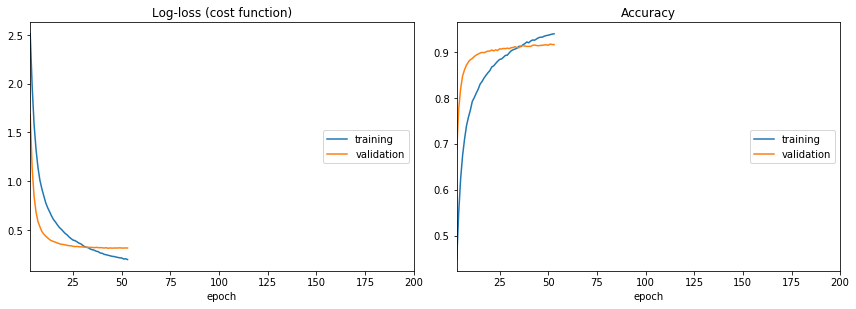

Log-loss (cost function):
training   (min:    0.195, max:    4.017, cur:    0.195)
validation (min:    0.310, max:    3.112, cur:    0.313)

Accuracy:
training   (min:    0.188, max:    0.940, cur:    0.940)
validation (min:    0.347, max:    0.917, cur:    0.916)
Restoring model weights from the end of the best epoch

Epoch 00053: ReduceLROnPlateau reducing learning rate to 6.399999838322402e-05.
Epoch 00053: early stopping


In [65]:
#----- model init and learning
init = Input(shape = (x_train.shape[1],))
drop = Dropout(.3)(init)
x = Dense(512, activation = 'relu')(drop)
drop = Dropout(.4)(x)
x = Dense(128, activation='relu')(drop)
drop = Dropout(.3)(x)
out = Dense(y_train.shape[1],
            activation = 'softmax')(drop)


net = Model(inputs = init, outputs = out)

net.compile(optimizer = Adam(learning_rate=.0001),
            loss = 'categorical_crossentropy',
            metrics = ['acc'])

fitted = net.fit(x_train,
                 y_train,
                  epochs = 200,
                 batch_size = 512,
                  validation_data = (x_test, y_test),
                  verbose = 0,
                 callbacks = [PlotLossesCallback(), es, reduce_lr]
                 )

In [66]:
#----- classification report
y_pred = net.predict(x_test)
y_pred = np.argmax(y_pred, axis = -1)

print(classification_report(np.argmax(y_test, axis = -1),
                            y_pred,
                            target_names = labels_dict.all().keys()))

                   precision    recall  f1-score   support

BACKGROUND_Google       0.79      0.77      0.78       234
            Faces       0.91      0.98      0.95       217
       Faces_easy       1.00      0.90      0.95       217
         Leopards       0.97      0.96      0.96       100
       Motorbikes       1.00      0.99      1.00       399
        accordion       1.00      1.00      1.00        27
        airplanes       0.98      0.99      0.99       400
           anchor       0.85      0.52      0.65        21
              ant       0.71      0.57      0.63        21
           barrel       0.96      0.96      0.96        23
             bass       0.80      0.74      0.77        27
           beaver       0.91      0.87      0.89        23
        binocular       0.89      1.00      0.94        16
           bonsai       0.93      0.98      0.95        64
            brain       0.90      0.88      0.89        49
     brontosaurus       0.81      0.81      0.81       

<div align = 'justify'>
<font size = 3>
La data augmentation non sembrerebbe fare la differenza nel caso della MobileNetV2, la composizione del test set influisce sempre pesantemente sulla misura delle prestazioni delle reti. I risultati in termini di accuracy e weighted avg f1-score sembrerebbero sostanzialmente identici.
</font>
</div>

### VGG16

In [69]:
#----- import data
with np.load(os.path.join(save_directory, "vgg16.npz")) as data:
  x_train = data['features']
  y_train = data['labels']

with np.load(os.path.join(save_directory, "vgg16_test.npz")) as data:
  x_test = data['features']
  y_test = data['labels']

labels_dict = np.load("gdrive/My Drive/Data.npy/labels_dict.npy", allow_pickle=True)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((4600, 512), (4544, 512), (4600, 102), (4544, 102))

In [0]:
#----- callbacks
es = EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = .8, patience = 5, min_lr = .00001, verbose = 1)

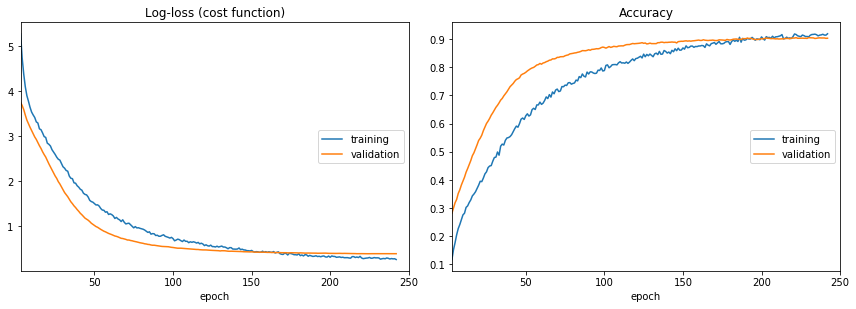

Log-loss (cost function):
training   (min:    0.256, max:   10.803, cur:    0.256)
validation (min:    0.384, max:    4.420, cur:    0.386)

Accuracy:
training   (min:    0.026, max:    0.919, cur:    0.919)
validation (min:    0.185, max:    0.905, cur:    0.903)

Epoch 00242: ReduceLROnPlateau reducing learning rate to 2.6214399258606137e-05.
Epoch 00242: early stopping


In [73]:
#----- model init and learning
init = Input(shape = (x_train.shape[1],))
drop = Dropout(.3)(init)
x = Dense(512, activation='relu')(drop)
#act = LeakyReLU()(x)
drop = Dropout(.4)(x)
x = Dense(128, activation = 'relu')(drop)
#act = LeakyReLU()(x)
drop = Dropout(.3)(x)
out = Dense(y_train.shape[1], activation = 'softmax')(drop)


net = Model(inputs = init, outputs = out)

net.compile(optimizer = #'adam',
            Adam(learning_rate=.0001),
            loss = 'categorical_crossentropy',
            metrics = ['acc'])

fitted = net.fit(x_train,
                 y_train,
                  epochs = 250,
                 batch_size = 128,
                  validation_data = (x_test, y_test),
                  verbose = 0
                 ,callbacks = [PlotLossesCallback(), es, reduce_lr]
                 )

In [74]:
#----- classification report
y_pred = net.predict(x_test)
y_pred = np.argmax(y_pred, axis = -1)

print(classification_report(np.argmax(y_test, axis = -1),
                            y_pred,
                            target_names = labels_dict.all().keys()))

                   precision    recall  f1-score   support

BACKGROUND_Google       0.79      0.71      0.75       234
            Faces       0.99      0.99      0.99       217
       Faces_easy       1.00      0.98      0.99       217
         Leopards       0.98      1.00      0.99       100
       Motorbikes       0.98      1.00      0.99       399
        accordion       0.93      1.00      0.96        27
        airplanes       0.99      1.00      1.00       400
           anchor       0.73      0.52      0.61        21
              ant       0.76      0.62      0.68        21
           barrel       0.96      0.96      0.96        23
             bass       0.77      0.74      0.75        27
           beaver       0.94      0.74      0.83        23
        binocular       0.93      0.81      0.87        16
           bonsai       0.95      0.92      0.94        64
            brain       0.85      0.96      0.90        49
     brontosaurus       0.64      0.67      0.65       

<div align = 'justify'><font size = 3>La VGG16 sembrerebbe raggiungere prestazioni leggermente inferiori rispetto alla MobileNetV2 per quanto riguarda questo task di classificazione ma non significativamente inferiori. Un elemento però da notare è che in ogni caso impiega più tempo (epoche) rispetto alla MobileNetV2 per convergere al "medesimo" risultato.</font></div>

### VGG16 augmented data

In [75]:
#----- import data
with np.load(os.path.join(save_directory, "vgg16_augmented.npz")) as data:
  x_train = data['features']
  y_train = data['labels']

with np.load(os.path.join(save_directory, "vgg16_test.npz")) as data:
  x_test = data['features']
  y_test = data['labels']

labels_dict = np.load("gdrive/My Drive/Data.npy/labels_dict.npy", allow_pickle=True)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((46000, 512), (4544, 512), (46000, 102), (4544, 102))

In [0]:
#----- callbacks
es = EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = .8, patience = 5, min_lr = .00001, verbose = 1)

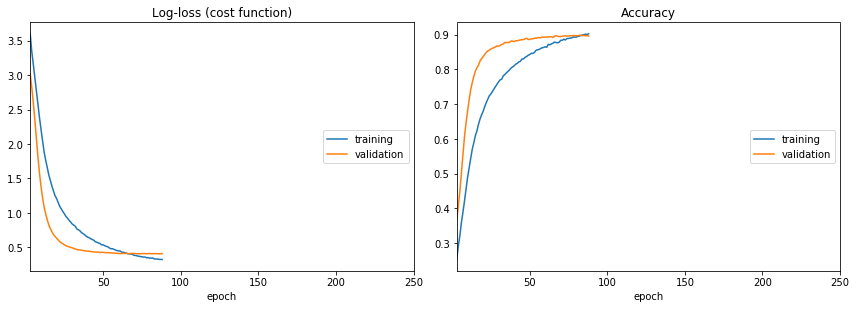

Log-loss (cost function):
training   (min:    0.322, max:    6.443, cur:    0.322)
validation (min:    0.405, max:    3.711, cur:    0.407)

Accuracy:
training   (min:    0.062, max:    0.903, cur:    0.903)
validation (min:    0.269, max:    0.899, cur:    0.896)

Epoch 00088: ReduceLROnPlateau reducing learning rate to 5.119999987073243e-05.
Epoch 00088: early stopping


In [80]:
#----- model init and learning
init = Input(shape = (x_train.shape[1],))
drop = Dropout(.3)(init)
x = Dense(512, activation='relu')(drop)
drop = Dropout(.4)(x)
x = Dense(128, activation = 'relu')(drop)
drop = Dropout(.3)(x)
out = Dense(y_train.shape[1], activation = 'softmax')(drop)


net = Model(inputs = init, outputs = out)

net.compile(optimizer = #'adam',
            Adam(learning_rate=.0001),
            loss = 'categorical_crossentropy',
            metrics = ['acc'])

fitted = net.fit(x_train,
                 y_train,
                  epochs = 250,
                 batch_size = 512,
                  validation_data = (x_test, y_test),
                  verbose = 0
                 ,callbacks = [PlotLossesCallback(), es, reduce_lr]
                 )

In [81]:
#----- classification report
y_pred = net.predict(x_test)
y_pred = np.argmax(y_pred, axis = -1)

print(classification_report(np.argmax(y_test, axis = -1),
                            y_pred,
                            target_names = labels_dict.all().keys()))

                   precision    recall  f1-score   support

BACKGROUND_Google       0.72      0.66      0.69       234
            Faces       0.96      0.98      0.97       217
       Faces_easy       1.00      0.96      0.98       217
         Leopards       0.94      0.95      0.95       100
       Motorbikes       0.99      1.00      0.99       399
        accordion       0.96      0.96      0.96        27
        airplanes       0.99      1.00      1.00       400
           anchor       0.90      0.43      0.58        21
              ant       0.79      0.52      0.63        21
           barrel       0.91      0.91      0.91        23
             bass       0.79      0.70      0.75        27
           beaver       0.85      0.74      0.79        23
        binocular       0.92      0.75      0.83        16
           bonsai       0.91      0.91      0.91        64
            brain       0.85      0.96      0.90        49
     brontosaurus       0.78      0.67      0.72       

Nonostante la data augmentation la VGG16 non sembra variare le proprie performances.

### ResNet50

In [82]:
#----- import data
with np.load(os.path.join(save_directory, "resnet50.npz")) as data:
  x_train = data['features']
  y_train = data['labels']

with np.load(os.path.join(save_directory, "resnet50_test.npz")) as data:
  x_test = data['features']
  y_test = data['labels']

labels_dict = np.load("gdrive/My Drive/Data.npy/labels_dict.npy", allow_pickle=True)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((4600, 2048), (4544, 2048), (4600, 102), (4544, 102))

In [0]:
#----- callbacks
es = EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = .8, patience = 5, min_lr = .00001, verbose = 1)

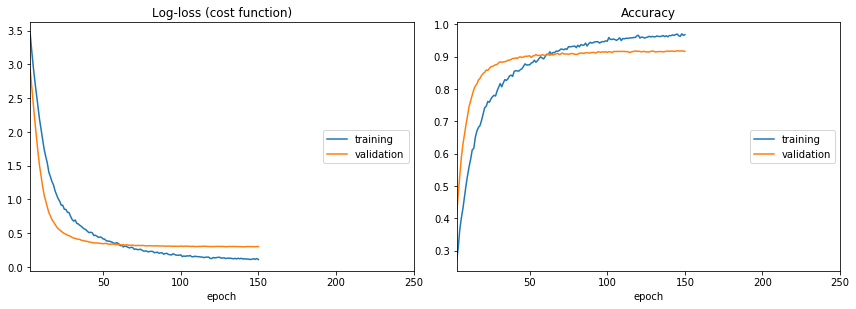

Log-loss (cost function):
training   (min:    0.111, max:    4.608, cur:    0.111)
validation (min:    0.298, max:    3.814, cur:    0.304)

Accuracy:
training   (min:    0.082, max:    0.971, cur:    0.968)
validation (min:    0.248, max:    0.919, cur:    0.917)

Epoch 00150: ReduceLROnPlateau reducing learning rate to 2.09715188248083e-05.
Epoch 00150: early stopping


In [85]:
#----- model init and learning
init = Input(shape = (x_train.shape[1],))
drop = Dropout(.3)(init)
x = Dense(512, activation ='relu')(drop)
drop = Dropout(.4)(x)
x = Dense(128, activation = 'relu')(drop)
drop = Dropout(.3)(x)
out = Dense(y_train.shape[1], activation = 'softmax')(drop)


net = Model(inputs = init, outputs = out)

net.compile(optimizer = Adam(learning_rate=.0001),
            loss = 'categorical_crossentropy',
            metrics = ['acc'])


fitted = net.fit(x_train,
                 y_train,
                  epochs = 250,
                 batch_size = 128,
                  validation_data = (x_test, y_test),
                  verbose = 0
                 ,callbacks = [PlotLossesCallback(), es, reduce_lr]
                 )

In [86]:
#----- classification report
y_pred = net.predict(x_test)
y_pred = np.argmax(y_pred, axis = -1)

print(classification_report(np.argmax(y_test, axis = -1),
                            y_pred,
                            target_names = labels_dict.all().keys()))

                   precision    recall  f1-score   support

BACKGROUND_Google       0.76      0.80      0.78       234
            Faces       0.98      0.98      0.98       217
       Faces_easy       1.00      0.97      0.98       217
         Leopards       0.96      0.95      0.95       100
       Motorbikes       0.99      1.00      0.99       399
        accordion       1.00      1.00      1.00        27
        airplanes       1.00      1.00      1.00       400
           anchor       0.88      0.33      0.48        21
              ant       0.79      0.52      0.63        21
           barrel       1.00      0.87      0.93        23
             bass       0.91      0.78      0.84        27
           beaver       0.94      0.70      0.80        23
        binocular       1.00      0.94      0.97        16
           bonsai       0.94      0.97      0.95        64
            brain       0.84      0.94      0.88        49
     brontosaurus       0.76      0.76      0.76       

La ResNet50 sembrerebbe attestare le sue prestazioni sullo stesso ordine di grandezza di quelle della MobileNetV2.

### ResNet50 augmented data

In [87]:
with np.load(os.path.join(save_directory, "resnet50_augmented.npz")) as data:
  x_train = data['features']
  y_train = data['labels']

with np.load(os.path.join(save_directory, "resnet50_test.npz")) as data:
  x_test = data['features']
  y_test = data['labels']

labels_dict = np.load("gdrive/My Drive/Data.npy/labels_dict.npy", allow_pickle=True)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((46000, 2048), (4544, 2048), (46000, 102), (4544, 102))

In [0]:
#----- callbacks
es = EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = .8, patience = 5, min_lr = .00001, verbose = 1)

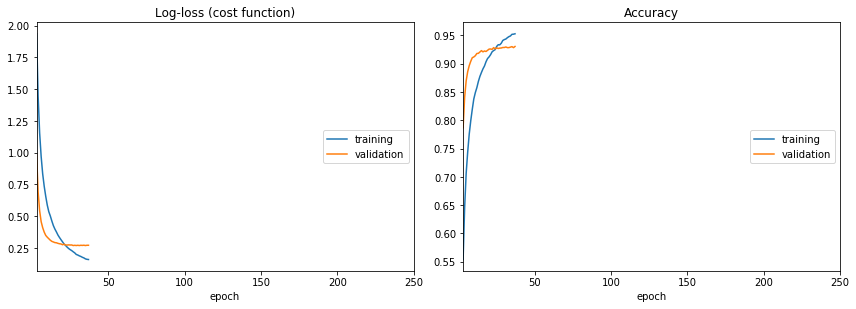

Log-loss (cost function):
training   (min:    0.160, max:    3.823, cur:    0.160)
validation (min:    0.270, max:    2.690, cur:    0.272)

Accuracy:
training   (min:    0.216, max:    0.953, cur:    0.953)
validation (min:    0.478, max:    0.930, cur:    0.930)

Epoch 00037: ReduceLROnPlateau reducing learning rate to 6.399999838322402e-05.
Epoch 00037: early stopping


In [105]:
#----- model init and learning
init = Input(shape = (x_train.shape[1],))
drop = Dropout(.3)(init)
x = Dense(512, activation ='relu')(drop)
drop = Dropout(.4)(x)
x = Dense(128, activation = 'relu')(drop)
drop = Dropout(.3)(x)
out = Dense(y_train.shape[1], activation = 'softmax')(drop)


net = Model(inputs = init, outputs = out)

net.compile(optimizer = Adam(learning_rate= .0001),
            loss = 'categorical_crossentropy',
            metrics = ['acc'])


fitted = net.fit(x_train,
                y_train,
                epochs = 250,
                batch_size = 512,
                validation_data = (x_test, y_test),
                verbose = 0,
                callbacks = [PlotLossesCallback(), es, reduce_lr])

In [106]:
#----- classification report
y_pred = net.predict(x_test)
y_pred = np.argmax(y_pred, axis = -1)

print(classification_report(np.argmax(y_test, axis = -1),
                            y_pred,
                            target_names = labels_dict.all().keys()))

                   precision    recall  f1-score   support

BACKGROUND_Google       0.82      0.78      0.80       234
            Faces       0.99      0.98      0.98       217
       Faces_easy       1.00      0.98      0.99       217
         Leopards       1.00      0.98      0.99       100
       Motorbikes       0.99      1.00      0.99       399
        accordion       0.96      1.00      0.98        27
        airplanes       0.99      1.00      0.99       400
           anchor       1.00      0.67      0.80        21
              ant       0.79      0.52      0.63        21
           barrel       1.00      0.91      0.95        23
             bass       0.88      0.81      0.85        27
           beaver       0.87      0.87      0.87        23
        binocular       0.94      0.94      0.94        16
           bonsai       0.95      0.97      0.96        64
            brain       0.85      0.96      0.90        49
     brontosaurus       0.86      0.86      0.86       

Anche se di poco, la ResNet50 abbinata all'augmentation sembrerebbe il modello migliore in termini di accuracy e weighted avg f1-score.

### Osservazioni

<div align='justify'>
<font size = 3>
Come detto in precendenza, il meccanismo di augmentation applicato, ovvero un 10x con variazioni sull'inclinazione dell'immagine, sullo shift in altezza e larghezza, sul ribaltamento orizzontale e lo zoom, nel caso di questo dataset in particolare, non sembrerebbe produrre miglioramenti apprezzabili per nessuna delle 3 reti pre-trainate utilizzate. Per quanto riguarda la reti in sè, invece, la VGG16 sembrerebbe essere quella a performare peggio tra tutte, mentre MobileNetV2 e ResNet50 sembrerebbero ottenere risultati molto simili. Inoltre come si può vedere dall'immagine VGG16 oltre a raggiungere le prestazioni peggiori è anche quella che pesa di più in memoria, rendendola del tutto svantaggiosa rispetto alle altre due soluzioni, più prestanti e leggere.
</font>
</div>
<br>
<div align = 'center'>
<img src = "https://miro.medium.com/max/831/1*g2WHSCnlo9JUMQdeXRqEzg.png" align='center'></div>